In [37]:
from IPython.core.display import display, HTML
from string import Template
import pandas as pd
import json, random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def open_json(filename):
    with open(filename, "r", encoding="utf-8") as read_file:
        data = json.load(read_file)
    return data

In [3]:
class Person:
    def __init__(self, dictionary):
        self.id = dictionary['id']
        self.name = dictionary['name']
        self.gender = dictionary['gender']
        if 'pids' in dictionary.keys():
            self.pids = dictionary['pids']
        if 'mid' in dictionary.keys():
            self.mid = dictionary['mid']
        if 'fid' in dictionary.keys():
            self.fid = dictionary['fid']
        self.cids = []
        self.rank = -1
        self.x = -1

    def __repr__(self):
        result = str(self.id) + ', ' + self.name + ', ' + self.gender
        if hasattr(self, 'pids'):
            result += ', ' + str(self.pids)
        if hasattr(self, 'mid'):
            result += ', ' + str(self.mid)
        if hasattr(self, 'fid'):
            result += ', ' + str(self.fid)
        if len(self.cids) != 0:
            result += ', ' + str(self.cids)
        result += ', ' + str(self.rank)
        result += ', ' + str(self.x)
        return '{' + result + '}'

In [4]:
def get_all_rank(tree, rank):
    result = []
    for id in tree:
        if tree[id].rank == str(rank):
            result.append(tree[id])
    return result

In [77]:
class FamilyTree:
    def __init__(self, tree_list):
        self.tree = {}
        if type(tree_list) is list:
            for node in tree_list:
                if type(node) is dict:
                    person = Person(node)
                    self.tree.update({person.id: person})
                else:
                    print("List must contains dict!")
        else:
            print("Tree must be list!")
        self.__add_children()
        self.__add_rank()

    def __add_children(self):
        result = self.tree
        for i in self.tree:
            if hasattr(self.tree[i], "mid"):
                result[self.tree[i].mid].cids.append(self.tree[i].id)
            if hasattr(self.tree[i], "fid"):
                result[self.tree[i].fid].cids.append(self.tree[i].id)
        self.tree = result

    def __add_rank(self):
        result = self.tree
        def add_rank_node(node, rank):
            if node.rank == -1:
                node.rank = str(rank)
                if hasattr(node, 'pids'):
                    for n in node.pids:
                        add_rank_node(result[n], rank)
            else:
                rank+=1
                if len(node.cids) != 0:
                    for n in node.cids:
                        add_rank_node(result[n], rank)
        add_rank_node(result[1], 0)
        self.tree = result

    def get_all_rank(self):
        ranks = []
        for person in self.tree.values():
            ranks.append(int(person.rank))
        return ranks

    def get_all_x(self):
        x = []
        for person in self.tree.values():
            x.append(person.x)
        return x

    def get_all_name(self):
        names = []
        for person in self.tree.values():
            names.append(person.name.split(" ")[0])
        return names

In [16]:
family_tree = FamilyTree(open_json('data/tree3_very_simple.json'))
family_tree.tree

{1: {1, Михаил Федорович, male, [2], [3], 0, -1},
 2: {2, Евдокия Лукьяновна Стрешнева, female, [1], [3], 0, -1},
 3: {3, Алексей Михайлович, male, 1, 2, 1, -1}}

In [7]:
def get_x_for_nodes(lst, center):
    result = []
    if len(lst)%2 == 0:
        half = len(lst)/2
        for i in np.arange(-half + 0.5, half - 0.4, 1.0):
            result.append(i + center)
    else:
        for i in range(len(lst)//2 - len(lst) + 1, len(lst)//2 + 1):
            result.append(i + center)
    return result

In [90]:
def set_x(tree, root_id):
    for i in tree:
        if hasattr(tree[i], 'pids'):
            setattr(tree[i], 'pids_tmp', tree[i].pids.copy())

    def set_x_person(person):
        if hasattr(person, 'pids_tmp'):
            for pid in person.pids_tmp:
                if tree[pid].x == -1:
                    tree[pid].x = person.x + 0.5
                children_id = list(set(person.cids) & set(tree[pid].cids))
                children_x = get_x_for_nodes(children_id, person.x + 0.25)
                for i in range(len(children_x)):
                    if tree[children_id[i]].x == -1:
                        tree[children_id[i]].x = children_x[i]
                        set_x_person(tree[children_id[i]])

                if person.id in tree[pid].pids_tmp:
                    tree[pid].pids_tmp.remove(person.id)

                set_x_person(tree[pid])

    tree[root_id].x = 0
    set_x_person(tree[root_id])

In [91]:
family_tree = FamilyTree(open_json('data/tree3_simple.json'))
set_x(family_tree.tree, 1)
family_tree.tree

{1: {1, Михаил Федорович, male, [2], [3], 0, 0},
 2: {2, Евдокия Лукьяновна Стрешнева, female, [1], [3], 0, 0.5},
 3: {3, Алексей Михайлович, male, [4], 1, 2, [6, 7, 8], 1, 0.25},
 4: {4, Мария Ильинична Милославская, female, [3], [6, 7, 8], 1, 0.75},
 6: {6, Федор Алексеевич, male, [9], 3, 4, 2, 0.5},
 7: {7, Софья Алексеевна, female, 3, 4, 2, 1.5},
 8: {8, Иоанн V Алексеевич, male, [10], 3, 4, [11, 12], 2, -0.5},
 9: {9, Марфа Матвеевна Апраксина, female, [6], 2, 1.0},
 10: {10, Прасковья Федоровна Салтыкова, female, [8], [11, 12], 2, 0.0},
 11: {11, Екатерина Иоановна, female, [13], 8, 10, [15], 3, -0.75},
 12: {12, Анна Иоановна, female, [14], 8, 10, 3, 0.25},
 13: {13, Карл Леопольд Мекленбург-Шверенский, male, [11], [15], 3, -0.25},
 14: {14, Фридрих Вильгельм Курляндский, male, [12], 3, 0.75},
 15: {15, Анна Леопольдовна, female, [16], 13, 11, [17], 4, -0.5},
 16: {16, Антон Ульрих Брауншвейг-Вольфенбюттельский, male, [15], [17], 4, 0.0},
 17: {17, Иоанн VI Антонович, male, 15, 

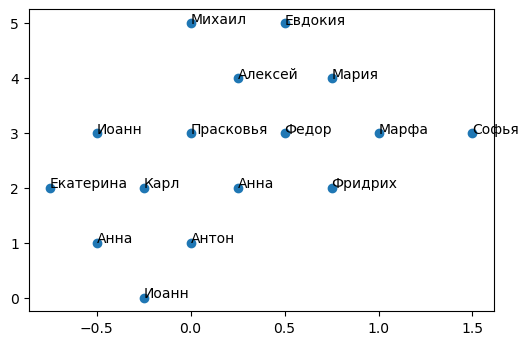

In [92]:
x = family_tree.get_all_x()
y =  family_tree.get_all_rank()
for i in range(len(y)):
    y[i] = max(y) - y[i]
n = family_tree.get_all_name()

fig, ax = plt.subplots(dpi = 100)
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

In [63]:
family_tree.get_all_names()

[0, 0, 0.5, 0, 1.0, 2.0, 0.0, 0, 0, 0.0, 1.0, 0, 0, 0.5, 0, 1.0]

3